Begin by importing the necessary libraries

In [78]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import seaborn to make pretty plots
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [3]:
# load the dataset
kc_data = pd.read_csv(r'C:\Users\Nick\Documents\Coursera\Applied Data Science Capstone\Final Project\KCPD_Crime_Data_2020_v2.csv', usecols = ['Zip Code','DVFlag', 'Reported_Date'])
pd.to_datetime(kc_data['Reported_Date'])

#Limit the incidents to only domestic violence
kc_data = kc_data.loc[kc_data['DVFlag'] == 'Y']
kc_data = kc_data.dropna()
#remove space in headers
kc_data.columns = kc_data.columns.str.replace(' ', '')
kc_data = kc_data.fillna(0)
#reduce the dataset size so we can make all the calls necessary for lat long coordinates
#kc_data = kc_data.tail(1500)
#print the dataset
kc_data.head()
#kc_data.dtypes

,Reported_Date,ZipCode,DVFlag
0,1/12/2020,64153,Y
1,2/24/2020,64153,Y
2,3/3/2020,64153,Y
3,1/31/2020,64153,Y
4,1/24/2020,64153,Y


In [4]:
kc_data.shape

(10098, 3)

Import a list of Kansas City zip codes with lat long coordinates from csv available on https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?q=kansas+city

In [5]:
k_zip = pd.read_csv(r'C:\Users\Nick\Documents\Coursera\Applied Data Science Capstone\Final Project\us-zip-code-latitude-and-longitude1.csv')
#
k_zip = k_zip.fillna(0)
k_zip.head(15)
#k_zip.dtypes

,Zip,City,State,Latitude,Longitude
0,64101.0,Kansas City,MO,39.103037,-94.60066
1,64102.0,Kansas City,MO,39.093854,-94.60411
2,64105.0,Kansas City,MO,39.104204,-94.58868
3,64106.0,Kansas City,MO,39.103704,-94.57311
4,64108.0,Kansas City,MO,39.084554,-94.58296
5,64109.0,Kansas City,MO,39.065954,-94.56643
6,64110.0,Kansas City,MO,39.033505,-94.57286
7,64111.0,Kansas City,MO,39.056505,-94.59439
8,64112.0,Kansas City,MO,39.037605,-94.59537
9,64113.0,Kansas City,MO,39.013638,-94.59471


Now we need to add the lat long coordinates based on the addresses, then reindex the crime reports. It was not actually possible to use the google API to determine the lat/long by zip code for me in this relatively useless portion of the course. Since there are duplicates, out of state zip codes, and incorrect values in the datasets, due to the inadequate nature of teaching data cleanings and python joins, I merged these tables in excel after many hours of trying to get calls to come back from the geocoder, outside of the python interface. 

In [6]:
#kc_data = kc_data.groupby('ZipCode')['DVFlag'].apply(', '.join).reset_index()
#Create a count per zip code of the domestic violence incidents
kc_data2 = kc_data.groupby('ZipCode')['DVFlag'].count()
#clip length of zipcode to 5 numbers
#kc_data.clip(upper=pd.Series({'ZipCode': 5}), axis=1)
kc_data2.head(46)

ZipCode
64101       5
64102      10
64105      47
64106     203
64108     192
64109     372
64110     297
64111     341
64112      31
64113      11
64114     232
64116     141
64117     274
64118     277
64119     232
64120      46
64121       2
64123     205
64124     317
64125      67
64126     210
64127     817
64128     484
64129     289
64130    1235
64131     568
64132     694
64133     291
64134     774
64136      28
64137     287
64138     276
64139       9
64145      36
64146       7
64147      21
64149       4
64151     202
64152      48
64153      56
64154     107
64155     152
64156      49
64157      93
64158      33
64161      24
Name: DVFlag, dtype: int64

In [7]:
# merge the count of the domestic violence incidents to the zip codes and lat/long coordinates
result = k_zip.merge(kc_data2, left_on='Zip', right_on='ZipCode')
# Rename the DVFlag column to DVCount
result = result.rename(columns = {'DVFlag':'DVCount'})
#Convert zipcode and DVcount from float to int
result['Zip'] = result['Zip'].astype(int)
result['DVCount'] = result['DVCount'].astype(int)
result
#result.shape
#N = 100
#thank you koalo for comment
#kc_data.ZipCode = np.round(kc_data.ZipCode*N).astype(int) 
#k_zip.Zip = np.round(k_zip.Zip*N).astype(int) 
#df = pd.merge(kc_data, k_zip, how = 'outer', on = ['Zip Code', 'Zip Code'])
#df.ZipCode = df.ZipCode / N

,Zip,City,State,Latitude,Longitude,DVCount
0,64101,Kansas City,MO,39.103037,-94.600660,5
1,64102,Kansas City,MO,39.093854,-94.604110,10
2,64105,Kansas City,MO,39.104204,-94.588680,47
3,64106,Kansas City,MO,39.103704,-94.573110,203
4,64108,Kansas City,MO,39.084554,-94.582960,192
5,64109,Kansas City,MO,39.065954,-94.566430,372
6,64110,Kansas City,MO,39.033505,-94.572860,297
7,64111,Kansas City,MO,39.056505,-94.594390,341
8,64112,Kansas City,MO,39.037605,-94.595370,31
9,64113,Kansas City,MO,39.013638,-94.594710,11


In [8]:
result.dtypes

Zip            int32
City          object
State         object
Latitude     float64
Longitude    float64
DVCount        int32
dtype: object

In [9]:
DV_pivot = result.pivot_table("DVCount","Zip")
DV_pivot.describe()

,DVCount
count,47.000000
mean,214.851064
std,254.549472
min,2.000000
25%,32.000000
50%,152.000000
75%,288.000000
max,1235.000000


Flip it around for the bar chart prep...

In [10]:
DV_counts = pd.DataFrame(result, columns=['Zip','DVCount'])
DV_counts

,Zip,DVCount
0,64101,5
1,64102,10
2,64105,47
3,64106,203
4,64108,192
5,64109,372
6,64110,297
7,64111,341
8,64112,31
9,64113,11


# load the dataset
kc_data = pd.read_csv(r'C:\Users\Nick\Documents\Coursera\Applied Data Science Capstone\Final Project\KCPD_Crime_Data_2020.csv')
pd.to_datetime(kc_data['Reported_Date'])

#Limit the incidents to only domestic violence
kc_data = kc_data.loc[kc_data['DVFlag'] == 'Y']
kc_data = kc_data.dropna()

#reduce the dataset size so we can make all the calls necessary for lat long coordinates
#kc_data = kc_data.tail(1500)
#print the dataset
kc_data.head()

Which Kansas City zip codes have the highest incidents of domestic violence during 2020?

In [11]:
# Sort the DV pivot table by the  highest number of incidents to lowest
DV_sort = pd.DataFrame(DV_pivot['DVCount'].sort_values(ascending=False))
# show the top 10 districts with the highest number of DV offenses
print("These are the top 10 zip codes with the highest number of domestic violence offenses:")
DV_sort.head(10)

These are the top 10 zip codes with the highest number of domestic violence offenses:


,DVCount
Zip,
64130,1235
64127,817
64134,774
64132,694
64131,568
64128,484
64109,372
64111,341
64124,317


Which Kansas City zip codes have the lowest frequency of domestic violence in 2020?

In [12]:
print("These are the 10 zip codes with the lowest number of domestic violence offenses:")
DV_sort.tail(10)

These are the 10 zip codes with the lowest number of domestic violence offenses:


,DVCount
Zip,
64161,24
64147,21
64113,11
64102,10
64139,9
64146,7
64101,5
64149,4
64121,2


In [13]:
# Create new dataframe with the top and bottom 10 districts according to total number of crimes
#DV_sort2 = DV_sort.sort_values(by=["DVCount"], ascending=False)
DV_sort2 = DV_counts.sort_values(by=["DVCount"], ascending=False).reset_index()
del DV_sort2['index']
DV_sort2.head(5)

,Zip,DVCount
0,64130,1235
1,64127,817
2,64134,774
3,64132,694
4,64131,568


In [14]:
DV_pivot2 = DV_pivot.sort_values(by=["DVCount"], ascending=False)
#del DV_pivot2['Zip']
DV_pivot2.head(5)

,DVCount
Zip,
64130,1235
64127,817
64134,774
64132,694
64131,568


Having sorted the new dataframe I would expect that the new bar plot follows suit, and it does.

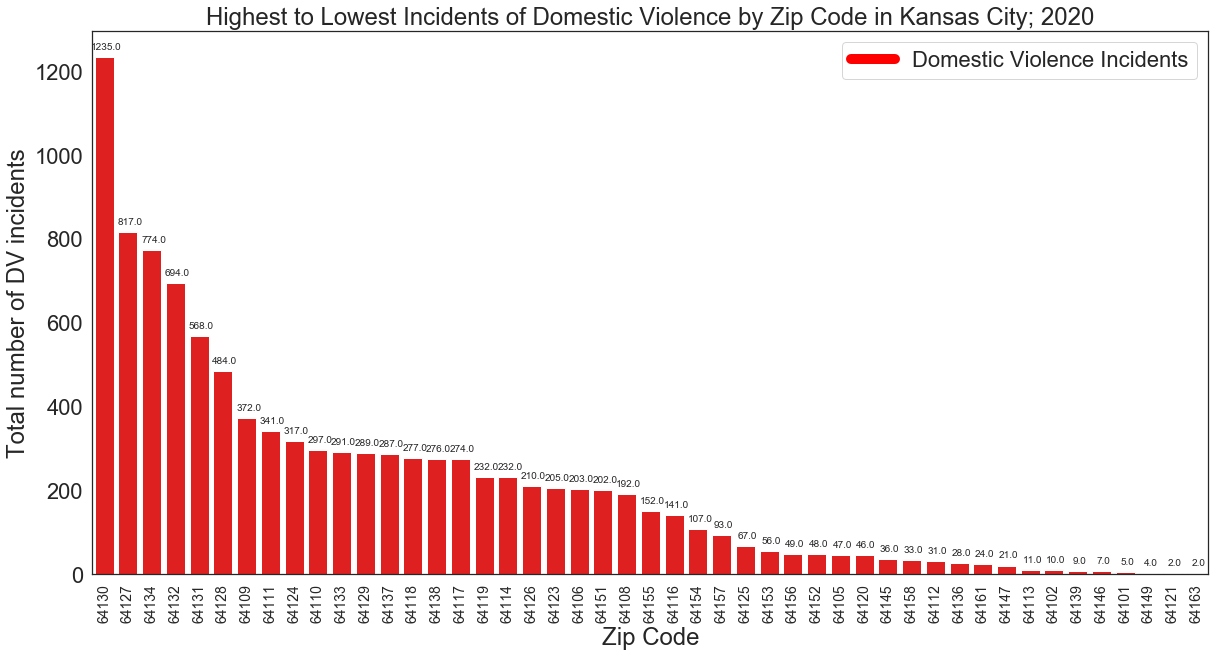

In [15]:
from matplotlib.lines import Line2D
sns.set(style="white", font_scale=2)

# create the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))
colors = ["red"]
custom_lines = [Line2D([0], [0], color="red", lw=10)]

# plot the graph of Total number of DV crimes in each neighborhood
barplot_alltypes = sns.barplot(x=DV_pivot2.index, y='DVCount', data=DV_pivot2, palette=colors, order = DV_pivot2.index)

# set the axis labels
ax.set_title('Highest to Lowest Incidents of Domestic Violence by Zip Code in Kansas City; 2020') # add title to the plot
ax.set(ylabel="Total number of DV incidents", xlabel="Zip Code")
ax.legend(custom_lines, ['Domestic Violence Incidents'])

# rotate xticklabels
barplot_alltypes.set_xticklabels(barplot_alltypes.get_xticklabels(),
                        rotation=90,
                        fontweight='light',
                        fontsize=14
                        )

for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=0), 
               (p.get_x()+p.get_width()/2., p.get_height()), 
               ha='center', 
               va='center', 
               xytext=(2, 10), 
               textcoords='offset points',
               fontsize = 10
              )

plt.show()

Now for clustering.

In [16]:
kc_grouped = result.groupby(["Zip"]).mean().reset_index()
print(kc_grouped.shape)
kc_grouped.head()

(47, 4)


,Zip,Latitude,Longitude,DVCount
0,64101,39.103037,-94.60066,5
1,64102,39.093854,-94.60411,10
2,64105,39.104204,-94.58868,47
3,64106,39.103704,-94.57311,203
4,64108,39.084554,-94.58296,192


Group into 8 k-means clusters to identify the DV counts in closest proximity

In [17]:
kclusters = 8
kc_clustering = kc_grouped.drop(["Zip"], 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kc_clustering)
kmeans.labels_[0:10]

array([0, 0, 0, 3, 3, 1, 7, 1, 0, 0])

Add cluster info back to mean table kc_grouped

In [18]:
# add cluster labels
kc_grouped_cluster = kc_grouped.copy()
kc_grouped_cluster["Cluster"] = kmeans.labels_

DV_geo = result[["Zip"]]
kc_merged = DV_geo

# merge wa_grouped_cluster with crime data to add latitude/longitude for each district
kc_merged = kc_merged.join(kc_grouped_cluster.set_index("Zip"), on="Zip")
kc_merged

,Zip,Latitude,Longitude,DVCount,Cluster
0,64101,39.103037,-94.600660,5,0
1,64102,39.093854,-94.604110,10,0
2,64105,39.104204,-94.588680,47,0
3,64106,39.103704,-94.573110,203,3
4,64108,39.084554,-94.582960,192,3
5,64109,39.065954,-94.566430,372,1
6,64110,39.033505,-94.572860,297,7
7,64111,39.056505,-94.594390,341,1
8,64112,39.037605,-94.595370,31,0
9,64113,39.013638,-94.594710,11,0


Let's put the information on a map. 

In [86]:
# Get the geographical coordinates of Seattle
address = 'Kansas City, MO'

geolocator = Nominatim(user_agent="kansas_explorer")
location_kc = geolocator.geocode(address)
latitude_kc = location_kc.latitude
longitude_kc = location_kc.longitude
print('The geographical coordinates of Kansas City are {}, {}.'.format(latitude_kc, longitude_kc))

The geographical coordinates of Kansas City are 39.100105, -94.5781416.


In [87]:
# visualize the map with clusters
map_clusters = folium.Map(location=[latitude_kc, longitude_kc], zoom_start=14.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kc_merged['Latitude'], kc_merged['Longitude'], kc_merged['Zip'], kc_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
#save the map as HTML file
map_clusters.save(r'C:\Users\Nick\Documents\Coursera\Applied Data Science Capstone\Final Project\map_clusters.html')

Determine the number of DV crimes per cluster

In [21]:
# number of crime records in each cluster
kc_merged.groupby(["Cluster"])["DVCount"].count()

Cluster
0    20
1     2
2     3
3     7
4     1
5     2
6     4
7     8
Name: DVCount, dtype: int64

In [22]:
# number of crime records per cluster per district
kc_cluster = kc_merged.groupby(["Cluster","Zip", "DVCount"]).size().rename("Counts_in_Clusters")
kc_cluster

Cluster  Zip    DVCount
0        64101  5          1
         64102  10         1
         64105  47         1
         64112  31         1
         64113  11         1
         64120  46         1
         64121  2          1
         64125  67         1
         64136  28         1
         64139  9          1
         64145  36         1
         64146  7          1
         64147  21         1
         64149  4          1
         64152  48         1
         64153  56         1
         64156  49         1
         64158  33         1
         64161  24         1
         64163  2          1
1        64109  372        1
         64111  341        1
2        64127  817        1
         64132  694        1
         64134  774        1
3        64106  203        1
         64108  192        1
         64114  232        1
         64119  232        1
         64123  205        1
         64126  210        1
         64151  202        1
4        64130  1235       1
5        64128  484

From the clusters we can examine the DV crime counts to define why the cluster was defined. Cluster 0: Contains the lowest incidents of domestic violence; Cluster 6: The second lowest DV crime incidents; Cluster 3: The third lowest DV crime incidents; Cluster 7: The fourth lowest DV Crime incidents; Cluster 1: fourth highest DV crime incidents; Cluster 5: third highest DV crime incidents; Cluster 2: second highest DV crime incidents; Cluster 4: highest DV Crime incidents 

Explore the zip codes within the clusters with the highest incidents of domestic violence.

In [64]:
kc_clusterdf = pd.DataFrame(kc_cluster)

#Delete counts_in_clusters column
del kc_clusterdf['Counts_in_Clusters']

kc_clusterdf.head()

Empty DataFrame
Columns: []
Index: [(0, 64101, 5), (0, 64102, 10), (0, 64105, 47), (0, 64112, 31), (0, 64113, 11)]

Delete all but the clusters with the highest rates of domestic violence. I use an earlier df here. 

In [88]:
DVcluster_filtered = kc_merged.iloc[[22, 23,25, 26,27,29 ] , : ]
DVcluster_filtered.head()

,Zip,Latitude,Longitude,DVCount,Cluster
22,64128,39.066754,-94.53650,484,5
23,64129,39.051455,-94.49660,289,7
25,64131,38.972473,-94.57656,568,5
26,64132,38.991406,-94.55100,694,2
27,64133,39.013905,-94.45910,291,7


Put the highest DV crime clusters on a map

In [95]:
# visualize the map with clusters
map_clusters2 = folium.Map(location=[latitude_kc, longitude_kc], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DVcluster_filtered['Latitude'], DVcluster_filtered['Longitude'], DVcluster_filtered['Zip'], DVcluster_filtered['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

In [96]:
#save the map as HTML file
map_clusters.save(r'C:\Users\Nick\Documents\Coursera\Applied Data Science Capstone\Final Project\DVmap_clusters.html')

The highest rates of domestic violence in KC appear on the south east Missouri side, centered near Raytown.

Put together a list of womens shelters. Wrote this out in a csv. Read the list of domestic violence shelters into python. Join the lat long of the shelter list. Add them to map.

In [76]:
k_shelters = pd.read_csv(r'C:\Users\Nick\Documents\Coursera\Applied Data Science Capstone\Final Project\DVshelters.csv')
#
k_shelters

,Name,Address,ZipCode
0,Friends of Yates,"1418 Garfield Avenue Kansas City, KS",66104
1,Synergy Services,"400 East 6th Street Parkville, MO",64152
2,Safehome Inc.,"PO Box 4563 Overland Park, KS",66204
3,Mother's Refuge,"3721 Delridge Rd Independence, MO",64055
4,Shelter KC,"2611 E. 11th Street Kansas City, MO",64127
5,"El Centro, Inc.","650 Minnesota Ave. Kansas City, KS",66101
6,Metropolitan Organization to Counter Sexual As...,"3100 Broadway, Suite 400 Kansas City, MO",64111


In [80]:
import geocoder
def get_latlng(address):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, KC'.format(address)) #geocoder.google is replaced with arcgis to make it go faster
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [83]:
# declare latitude and longitude as an empty list to initialize
latitude = []
longitude = []

# Use function get_latlng to get latitude and longitude for every neighborhood in the dataset  
for address in (k_shelters["Address"]):
    if get_latlng(address) != None:
        loc = get_latlng(address)
        # returned coordinates returned are stored into the latitude and longitude list
        latitude.append(loc[0])
        longitude.append(loc[1])
        
        #if coordinates are not found, insert "NaN" indicating missing value
    else:
        print(i)
        latitude.append(np.nan)
        longitude.append(np.nan)

Add the coordinates to the womens shelters list

In [85]:
# Add latitude and longitude data to dataframe
k_shelters["Latitude"] = latitude
k_shelters["Longitude"] = longitude
k_shelters

,Name,Address,ZipCode,Latitude,Longitude
0,Friends of Yates,"1418 Garfield Avenue Kansas City, KS",66104,39.125983,-94.645101
1,Synergy Services,"400 East 6th Street Parkville, MO",64152,39.191914,-94.678679
2,Safehome Inc.,"PO Box 4563 Overland Park, KS",66204,38.985800,-94.671610
3,Mother's Refuge,"3721 Delridge Rd Independence, MO",64055,39.054243,-94.456902
4,Shelter KC,"2611 E. 11th Street Kansas City, MO",64127,39.100266,-94.551020
5,"El Centro, Inc.","650 Minnesota Ave. Kansas City, KS",66101,39.115727,-94.626596
6,Metropolitan Organization to Counter Sexual As...,"3100 Broadway, Suite 400 Kansas City, MO",64111,39.070635,-94.590631


Add these to the map.

In [ ]:
# visualize the map with clusters
map_clusters3 = folium.Map(location=[latitude_kc, longitude_kc], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DVcluster_filtered['Latitude'], DVcluster_filtered['Longitude'], DVcluster_filtered['Zip'], DVcluster_filtered['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters3)
#Add DV shelters to map
for lat, lon in zip(k_shelters['Latitude'], k_shelters['Longitude'], DVcluster_filtered['Zip'], DVcluster_filtered['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters3